In [8]:
import gpxpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
with open('取桃計畫.gpx', 'r', encoding='utf-8') as f:
    gpx = gpxpy.parse(f)

points = []
for track in gpx.tracks:
    for segment in track.segments:
        for p in segment.points:
            points.append({
                'time': p.time,  # 時間戳記
                'lat': p.latitude,  # 緯度
                'lon': p.longitude,  # 經度
                'ele': p.elevation  # 海拔
            })

df = pd.DataFrame(points)


df.head()

,time,lat,lon,ele
0,2025-05-22 19:34:32+00:00,24.397230,121.307146,1892.000000
1,2025-05-22 19:34:35+00:00,24.397230,121.307146,1913.300049
2,2025-05-22 19:35:13+00:00,24.397208,121.307190,1892.000000
3,2025-05-22 19:35:56+00:00,24.397145,121.307230,1892.000000
4,2025-05-22 19:36:10+00:00,24.397090,121.307248,1893.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2188 entries, 0 to 2187
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype                        
---  ------  --------------  -----                        
 0   time    2188 non-null   datetime64[ns, SimpleTZ('Z')]
 1   lat     2188 non-null   float64                      
 2   lon     2188 non-null   float64                      
 3   ele     2188 non-null   float64                      
dtypes: datetime64[ns, SimpleTZ('Z')](1), float64(3)
memory usage: 68.5 KB


In [24]:
def haversine(lat1, lon1, lat2, lon2): # 半正矢公式: 根據兩點的經度和緯度來確定大圓上兩點之間距離的計算方法
    R = 6371e3 # 地球半徑: 6371*10**3 =6,371,000 公尺
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = phi2 - phi1
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

distances, time_deltas, slopes = [0], [0], [0]
for i in range(1, len(df)):
    d = haversine(df['lat'].iloc[i-1], df['lon'].iloc[i-1], df['lat'].iloc[i], df['lon'].iloc[i]) # 算距離
    distances.append(d)
    dt = (df['time'].iloc[i] - df['time'].iloc[i-1]).total_seconds()
    time_deltas.append(dt)
    elev_diff = df['ele'].iloc[i] - df['ele'].iloc[i-1] # 從海拔算高度差
    slope = (elev_diff / d)*100 if d != 0 else 0 # 坡度計算
    slopes.append(slope)

df['segment_distance'] = distances # 兩點之間的水平距離（公尺）
df['cum_distance'] = df['segment_distance'].cumsum() / 1000 # 累進距離(公里)
df['time_delta_sec'] = time_deltas # 每次紀錄的時間間距
df['speed_kmh'] = df['segment_distance'] / df['time_delta_sec'] * 3.6 # 當段移動的瞬時速度（公里/小時）
df['slope_percent'] = slopes # 兩個相鄰點之間的坡度（百分比）。算法：高度差（elev_diff）除以水平距離，再乘以 100。

df.head()

,time,lat,lon,ele,segment_distance,cum_distance,time_delta_sec,speed_kmh,slope_percent
0,2025-05-22 19:34:32+00:00,24.397230,121.307146,1892.000000,0.000000,0.000000,0.0,NaN,0.000000
1,2025-05-22 19:34:35+00:00,24.397230,121.307146,1913.300049,0.000000,0.000000,3.0,0.000000,0.000000
2,2025-05-22 19:35:13+00:00,24.397208,121.307190,1892.000000,5.088791,0.005089,38.0,0.482096,-418.567968
3,2025-05-22 19:35:56+00:00,24.397145,121.307230,1892.000000,8.130316,0.013219,43.0,0.680678,0.000000
4,2025-05-22 19:36:10+00:00,24.397090,121.307248,1893.000000,6.363574,0.019583,14.0,1.636348,15.714439


In [ ]:
# 記錄日期
record_date = df['time'].iloc[0].date()

# 總移動距離：累進距離的最後一個值
total_distance_km = df['cum_distance'].iloc[-1]

# 花費時間：起點到終點的時間差
total_duration_sec = (df['time'].iloc[-1] - df['time'].iloc[0]).total_seconds()
total_duration_str = pd.to_timedelta(total_duration_sec, unit='s')

# 計算每段爬升/下降
elev_diffs = df['ele'].diff().fillna(0)

# 總爬升：累積所有正的高度差
total_ascent = elev_diffs[elev_diffs > 0].sum()

# 總下降：累積所有負的高度差的絕對值
total_descent = - elev_diffs[elev_diffs < 0].sum()

print(f"記錄日期: {record_date}")
print(f"里程: {total_distance_km:.2f} 公里")
print(f"花費時間: {total_duration_str}")
# 不知道為啥跟健行筆記不一樣 不知道他甚麼算法
print(f"總爬升高度: {total_ascent:.2f} 公尺")
print(f"總下降高度: {total_descent:.2f} 公尺")


記錄日期: 2025-05-22
里程: 13.44 公里
花費時間: 0 days 07:29:56
總爬升高度: 3011.30 公尺
總下降高度: 3016.30 公尺


![](test.png)

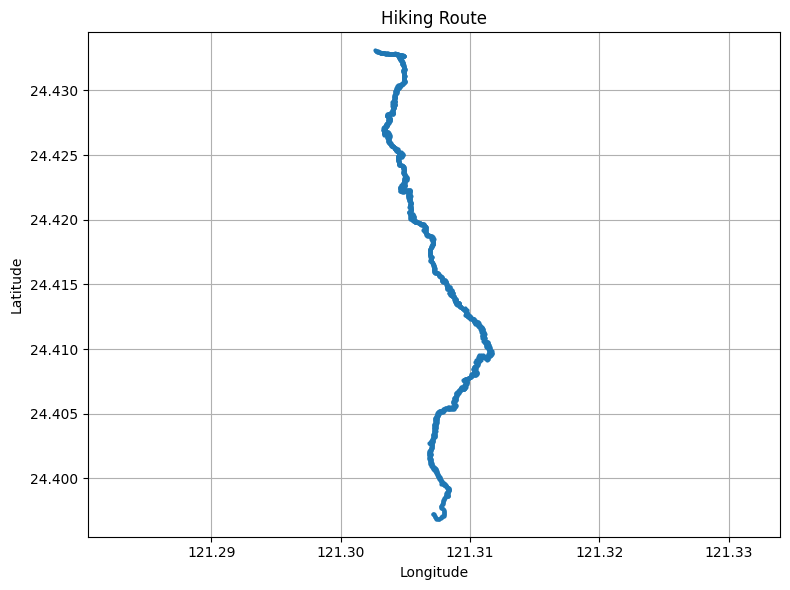

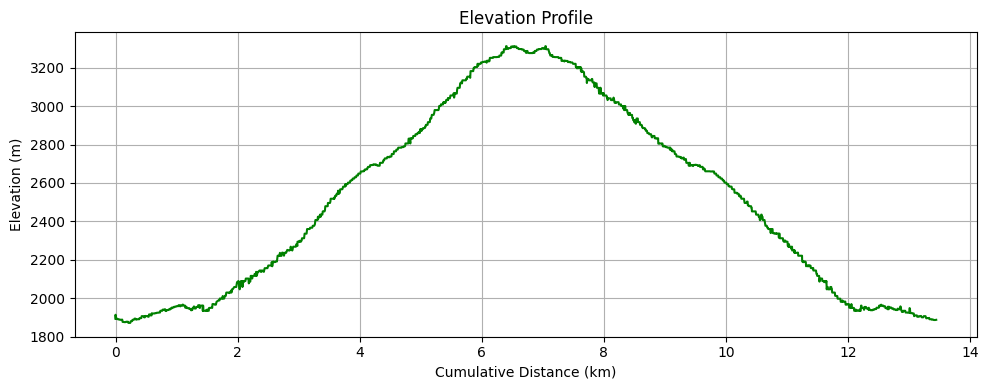

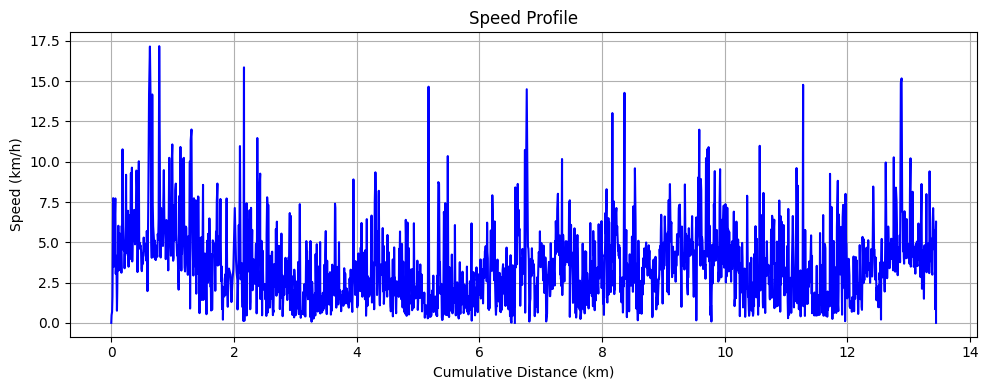

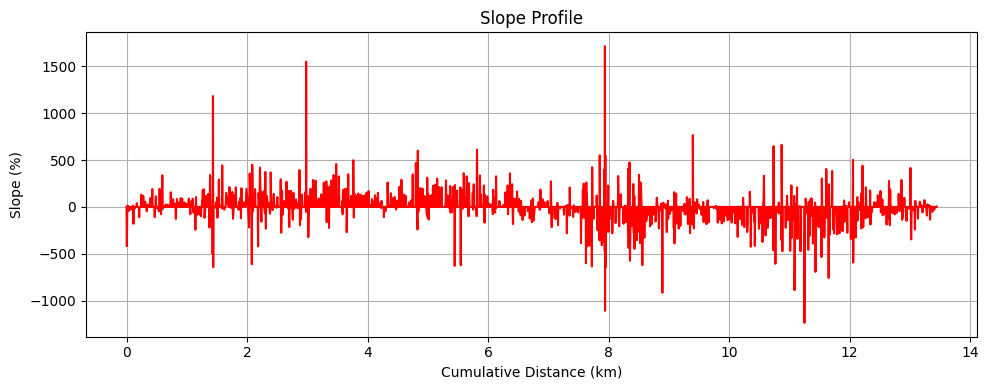

In [ ]:
# 1) 行進路線圖：經緯度平面
plt.figure(figsize=(8, 6))
plt.plot(df['lon'], df['lat'], marker='o', markersize=2, linewidth=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hiking Route')
plt.grid(True)
plt.axis('equal') # 設定x/y軸比例相等 這樣才會像地圖
plt.tight_layout()
plt.show()

# 2) 高度曲線：累積距離 vs 高度
plt.figure(figsize=(10, 4))
plt.plot(df['cum_distance'], df['ele'], color='green')
plt.xlabel('Cumulative Distance (km)')
plt.ylabel('Elevation (m)')
plt.title('Elevation Profile')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) 行進速率分布：速度 vs 累積距離
plt.figure(figsize=(10, 4))
plt.plot(df['cum_distance'], df['speed_kmh'], color='blue')
plt.xlabel('Cumulative Distance (km)')
plt.ylabel('Speed (km/h)')
plt.title('Speed Profile')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) 坡度分布：坡度 vs 累積距離
plt.figure(figsize=(10, 4))
plt.plot(df['cum_distance'], df['slope_percent'], color='red')
plt.xlabel('Cumulative Distance (km)')
plt.ylabel('Slope (%)')
plt.title('Slope Profile')
plt.grid(True)
plt.tight_layout()
plt.show()
